## Hello, Trupanion Data Science team! 

My name is Tony Loiseleur, and welcome to my work on the Trupanion Data Science Skill Assessment!

Given my background as a writer, I thought it would be good to add some commentary between the code cells, explaining my thoughts and process as I addressed the assessment's two parts. We'll get started shortly, but first off, thank you for taking the time to review my assessment and for your consideration of my candidacy for the role.

Right, that said, let's dive right in!

> ### Part 1 – Modeling
> *As an insurance company, we collect premium on a monthly basis from our customers. We then cover the customer’s veterinary bills should their pets receive medical treatment. Given the attached claim and pet data, predict how much we’ll pay in claims per pet in the following month.*
>
> *- To clarify, __I’m expecting a predicted sum for every PetId for the month of July 2019,__ along with the code you used to generate the solution*

As I understand it, a model that helps figure out how much a customer is likely to claim in a given month (or in this case, in July 2019) will likely make it easier for Trupanion to project profits for that same month.

Seems like straightforward enough problem and use case, right? (Right!)

In [1]:
# These are the tools I'll be using. This first block is standard imports that I bring into every notebook:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# These imports help manipulate datetime objects in a way that will keep from excluding certain PetId edge cases
# (e.g. customers that are insured for only one month, whether they claimed or not during that time):
from pandas.tseries.offsets import MonthEnd, MonthBegin

# And finally, these are the modeling tools I'll be using:
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# And now, we import our two CSVs of data and put them into Pandas dataframes for easier viewing:
claimdata = pd.read_csv("claimdata.csv")
petdata = pd.read_csv("petdata.csv")

In [3]:
# Let's take a look at both of our DFs and get some basic info on them:
print(claimdata.info())
claimdata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37049 entries, 0 to 37048
Data columns (total 4 columns):
ClaimId        37049 non-null int64
PetId          37049 non-null int64
ClaimDate      37049 non-null object
ClaimAmount    37049 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ MB
None


,ClaimId,PetId,ClaimDate,ClaimAmount
0,0,9273,2014-02-25,389.65
1,1,1988,2014-03-10,455.40
2,2,2452,2014-04-02,1953.79
3,3,3658,2014-04-05,243.74
4,5,9147,2014-03-18,206.42


In [4]:
print(petdata.info())
petdata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
PetId          10000 non-null int64
EnrollDate     10000 non-null object
CancelDate     4879 non-null object
Species        10000 non-null object
Breed          10000 non-null object
AgeAtEnroll    10000 non-null object
dtypes: int64(1), object(5)
memory usage: 468.8+ KB
None


,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old
3,3,2015-01-09,2015-01-14,Dog,Mixed Breed,1 year old
4,4,2014-07-20,NaN,Cat,Mixed Breed,8 weeks to 12 months old


So, here's the gameplan: rather than using these dataframes as they are to create a model, I think it would probably be best to make a new one with key elements (and more!) from both. 

In order to create a model that can predict claims in July 2019, we'll need to create target values of monthly claims that each customer received for every month prior to July. That means grouping our customers by their unique PetId, and then aggregating their total claim amount for each month they were insured.

This preparation step is important as we'll be training our model on a portion of this newly engineered dataframe in order to give the model the ability to predict monthly claims all on its own. The portion of the data that it doesn't use for training becomes the benchmark by which we'll test how accurate the model is.

Diving right into feature engineering, one immediate thing I can do to make things a little easier is to transform the three date columns from text strings into datetime objects in our pet and claim dataframes.

In [5]:
# Changing my date cols to datetime:
claimdata["ClaimDate"] = pd.to_datetime(claimdata["ClaimDate"])
petdata["EnrollDate"] = pd.to_datetime(petdata["EnrollDate"])
petdata["CancelDate"] = pd.to_datetime(petdata["CancelDate"])

Unsurprisingly, there's a lot of useful information in the `claimdata` dataframe. To use a Random Forest Regressor model to predict monthly claim amounts, what I want to do first is to accurately portray both the months that our customers claimed and didn't claim any insurance.

As mentioned above, I'll need to create a whole new dataframe with the months that a customer is actively covered/enrolled, followed by pulling claim data from the `claimdata` DF into that "monthly service" DF for all the months they claimed.

In [6]:
# First, we create the monthly service template, which will be home to the aggregated claims data per month, 
# per unique customer. (We'll be nixing the ClaimId column, since summing those makes no sense, and won't be
# useful to us in the long run, however):
monthly_total_claims = claimdata.copy()

# You'll notice here that I push the ClaimDates to the end of the month. This allows us to later join this DF 
# on shared dates to our all_pet_history DF in the coming steps:
monthly_total_claims["ServiceDate"] = monthly_total_claims["ClaimDate"].apply(lambda x: x + MonthEnd(1))

# This is the aggregation bit:
monthly_total_claims = monthly_total_claims.groupby(by=["PetId", "ServiceDate"]).sum()

# And as mentioned, I'm dropping the ClaimId column here since it's of no use to us any longer:
monthly_total_claims.drop("ClaimId", axis=1, inplace=True)

monthly_total_claims.reset_index(inplace=True)
monthly_total_claims.head()

,PetId,ServiceDate,ClaimAmount
0,2,2015-12-31,75.32
1,2,2016-01-31,61.06
2,2,2017-06-30,63.25
3,2,2017-07-31,144.12
4,2,2017-12-31,833.25


With our `monthly_total_claims` DF done, we now build our pet service history DF.

In [7]:
# Generating unique PetIds so that I can iterate through them in the next few steps. (Sit tight, this may take
# a few minutes):
pet_ids = petdata["PetId"].unique()

# Creating the DF to concatenate to with the relevant columns:
all_pet_history_df = pd.DataFrame(columns=["PetId", "EnrollDate"])

for pet in pet_ids:
    enroll_date = petdata[petdata["PetId"] == pet]["EnrollDate"].values[0]
    beginning_of_month_enroll = pd.to_datetime(enroll_date) - MonthBegin(1)
    # Finding the last date for the service range is tricky, since not all customers have canceled:
    if pd.isnull(petdata[petdata["PetId"] == pet]["CancelDate"].values[0]):
        cancel_date = pd.to_datetime("2019-06-30")
    else:
        # This looks a little twisty, and it is, but for a reason. If a customer is still insured after
        # 30 June 2019, for the purposes of the model, we'll want to say their end date is in June. This
        # is because we don't have values to test against beyond June 2019.
        if (petdata[petdata["PetId"] == pet]["CancelDate"].values[0]) > (np.datetime64("2019-06-30")):
            cancel_date = pd.to_datetime("2019-06-30")
        else:
            # This is the original line
            cancel_date = petdata[petdata["PetId"] == pet]["CancelDate"].values[0]
            
    end_of_month_cancel = pd.to_datetime(cancel_date) + MonthEnd(1)

    # This is where we create our date range of insurance for a given pet (until 30 June 2019, of course):
    service_date_ranges = pd.date_range(start=beginning_of_month_enroll, 
                                        end=end_of_month_cancel, freq="M", closed="right")

    # Creating a unique DF for our given pet's insurance history:
    pet_history_df = pd.DataFrame(np.zeros((len(service_date_ranges), 2)), index=service_date_ranges, 
                                  columns=["PetId", "EnrollDate"])

    pet_history_df["PetId"] = pet
    pet_history_df["EnrollDate"] = enroll_date

    all_pet_history_df = pd.concat([all_pet_history_df, pet_history_df])
    
all_pet_history_df.head()

,PetId,EnrollDate
2015-08-31,0,2015-08-11
2015-09-30,0,2015-08-11
2015-10-31,0,2015-08-11
2015-11-30,0,2015-08-11
2015-12-31,0,2015-08-11


Awesome! We have our service history "template", as it were.

All we need to do now is bring over our monthly claims from `monthly_total_claims` DF.

In [8]:
# This is where we pull the total claim amounts for every month for each unique pet and slot them into 
# the all_pet_history_df. Again, this will show us all the months a pet has been covered by insurance
# and how much they received for the months that they claimed while enrolled:

# Here, we reset the index so that it's easier to manipulate the ServiceDate column:
all_pet_history_df.reset_index(inplace=True)
all_pet_history_df.rename(columns={"index":"ServiceDate"}, inplace=True)

# Also printing length of the DFs before and after, just as a sanity check:
print("Length before: ", len(all_pet_history_df))
combined_df = pd.merge(all_pet_history_df.copy(), monthly_total_claims, on=["ServiceDate", "PetId"], how="left")
print("Length after:  ", len(combined_df))
combined_df.head()

Length before:  324207
Length after:   324207


,ServiceDate,PetId,EnrollDate,ClaimAmount
0,2015-08-31,0,2015-08-11,NaN
1,2015-09-30,0,2015-08-11,NaN
2,2015-10-31,0,2015-08-11,NaN
3,2015-11-30,0,2015-08-11,NaN
4,2015-12-31,0,2015-08-11,NaN


In [9]:
# Double-checking, that customers that have claimed have their claims recorded in the DF 
# (PetId 14 is certainly one of those customers):
combined_df[combined_df["PetId"] == 14].head(8)

,ServiceDate,PetId,EnrollDate,ClaimAmount
369,2010-11-30,14,2010-11-13,NaN
370,2010-12-31,14,2010-11-13,NaN
371,2011-01-31,14,2010-11-13,NaN
372,2011-02-28,14,2010-11-13,NaN
373,2011-03-31,14,2010-11-13,26.48
374,2011-04-30,14,2010-11-13,NaN
375,2011-05-31,14,2010-11-13,736.01
376,2011-06-30,14,2010-11-13,NaN


As we can see above, we have a lot of entries in the "ClaimAmount" column that are NaNs. That essentially means $0.00 as they're occurring in months where the particular customer made no claims, so in the next cell, we'll fill those in as 0.00.

In [10]:
# Confirming that we have a bunch of NaNs in the ClaimAmount col, which we'll eventually change to 0.00, 
# since the NaNs functionally indicate months where claims weren't made (and thus cost $0.00):

print(combined_df.info())
combined_df["ClaimAmount"].fillna(0.0, inplace=True)
combined_df[combined_df["PetId"] == 14].head(8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324207 entries, 0 to 324206
Data columns (total 4 columns):
ServiceDate    324207 non-null datetime64[ns]
PetId          324207 non-null object
EnrollDate     324207 non-null datetime64[ns]
ClaimAmount    22675 non-null float64
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 12.4+ MB
None


,ServiceDate,PetId,EnrollDate,ClaimAmount
369,2010-11-30,14,2010-11-13,0.00
370,2010-12-31,14,2010-11-13,0.00
371,2011-01-31,14,2010-11-13,0.00
372,2011-02-28,14,2010-11-13,0.00
373,2011-03-31,14,2010-11-13,26.48
374,2011-04-30,14,2010-11-13,0.00
375,2011-05-31,14,2010-11-13,736.01
376,2011-06-30,14,2010-11-13,0.00


With that sorted, now we can start adding features onto this dataframe that we'll use in our model.

In [11]:
# This is where we start playing around with features I want to engineer (always a good idea to save a copy of
# the original DF, just in case I make a mistake adding or engineering features):
petdata_feature_eng = petdata.copy()

# First, we dummy the categorical columns for breed and age, minding that we should drop a single column 
# in each dummy category we're creating them for. Along thoes lines, "Ragdoll" is apparently a type of cat, 
# and so dropping that column along with the "Species_Cat" dummy should work well here. For example, 
# if it's not a dog, and not any of the other dog breeds, and it isn't a mixed breed cat (e.g., Species_Dog = 0, 
# Breed_Mixed_Breed = 1), it's probably a ragdoll cat (e.g., Species_Dog = 0, Breed_Mixed_Breed = 0):
petdata_feature_eng = pd.get_dummies(petdata_feature_eng, columns=["Species", "Breed"])
petdata_feature_eng.drop(["Species_Cat", "Breed_Ragdoll"], axis=1, inplace=True)

# It's better to have a numerical representation of enrollment age, rather than text strings: 
ages_in_months_dict = {"0-7 weeks old": 0, "8 weeks to 12 months old": 0.7, "1 year old": 12, "2 years old": 24,
                       "3 years old": 36, "4 years old": 48, "5 years old": 60, "6 years old": 72, 
                       "7 years old": 84, "8 years old": 96, "9 years old": 108, "10 years old": 120,
                       "11 years old": 132, "12 years old": 144, "13 years old": 156}

# What's the minimum age in months that a pet enrolled with our service? (This will come in handy 
# later for another feature)
petdata_feature_eng["MinAgeMonthsAtEnroll"] = np.NaN
petdata_feature_eng["MinAgeMonthsAtEnroll"] = petdata_feature_eng["AgeAtEnroll"].apply(lambda x: ages_in_months_dict[x])

# Is this PetId still active and with the service?
petdata_feature_eng["ActiveCustomer"] = petdata_feature_eng["CancelDate"].apply(lambda x: pd.isnull(x))

# Add a column to combined_df that takes datetimes and turns them back into integers, since our random forest
# doesn't like playing with datetimes:
combined_df["ServiceDateAsInt"] = combined_df["ServiceDate"].apply(lambda x: int(x.strftime("%Y%m")))
combined_df["EnrollDateAsInt"] = combined_df["EnrollDate"].apply(lambda x: int(x.strftime("%Y%m")))

# Eventually, we won't really need EnrollDate and ServiceDate for petdata_feature_eng since we'll be 
# merging it with combined_w_feat_df:

petdata_feature_eng.head()

,PetId,EnrollDate,CancelDate,AgeAtEnroll,Species_Dog,Breed_Chihuahua,Breed_French Bulldog,Breed_Golden Retriever,Breed_Great Dane,Breed_Mixed Breed,MinAgeMonthsAtEnroll,ActiveCustomer
0,0,2015-08-11,2018-07-13,5 years old,1,0,0,0,0,1,60.0,False
1,1,2014-02-15,2016-01-25,3 years old,0,0,0,0,0,1,36.0,False
2,2,2014-12-20,NaT,8 weeks to 12 months old,1,0,1,0,0,0,0.7,True
3,3,2015-01-09,2015-01-14,1 year old,1,0,0,0,0,1,12.0,False
4,4,2014-07-20,NaT,8 weeks to 12 months old,0,0,0,0,0,1,0.7,True


In [12]:
# And now we roll in the above features DF with our combined_df to make a super-duper feature-rich DF:
combined_w_feat_df = combined_df.copy()

# Length sanity checks, like when we made our service history DF, above:
print("Length before: ", len(combined_w_feat_df))
combined_w_feat_df = pd.merge(combined_w_feat_df, petdata_feature_eng, on="PetId", how="left")
print("Length after:  ", len(combined_w_feat_df))

# And cleaning up our EnrollDate column(s):
combined_w_feat_df.drop("EnrollDate_y", axis=1, inplace=True)
combined_w_feat_df.rename(columns={"EnrollDate_x":"EnrollDate"}, inplace=True)

combined_w_feat_df.head()

Length before:  324207
Length after:   324207


,ServiceDate,PetId,EnrollDate,ClaimAmount,ServiceDateAsInt,EnrollDateAsInt,CancelDate,AgeAtEnroll,Species_Dog,Breed_Chihuahua,Breed_French Bulldog,Breed_Golden Retriever,Breed_Great Dane,Breed_Mixed Breed,MinAgeMonthsAtEnroll,ActiveCustomer
0,2015-08-31,0,2015-08-11,0.0,201508,201508,2018-07-13,5 years old,1,0,0,0,0,1,60.0,False
1,2015-09-30,0,2015-08-11,0.0,201509,201508,2018-07-13,5 years old,1,0,0,0,0,1,60.0,False
2,2015-10-31,0,2015-08-11,0.0,201510,201508,2018-07-13,5 years old,1,0,0,0,0,1,60.0,False
3,2015-11-30,0,2015-08-11,0.0,201511,201508,2018-07-13,5 years old,1,0,0,0,0,1,60.0,False
4,2015-12-31,0,2015-08-11,0.0,201512,201508,2018-07-13,5 years old,1,0,0,0,0,1,60.0,False


Our new `combined_w_feat_df` data frame is shaping up pretty well at this point! 

That being said, it's still not exactly complete, as we can engineer and add more useful features for our model now that we've introduced monthly observations as our row (rather than unique pets per row, as in the `petdata_features_eng` DF).

If I'm being completely honest, the new features below were things I thought to add only after my first few forays into creating a model without them. You can probably imagine how discouraging those results were, so if there's any valuable personal lesson for me to understand here, it's that data science is an iterative process!

In [13]:
# Further feature engineering is now possible! Now that we've got values for minimum age at enroll, 
# we can figure out how old our pet likely is at each month they're customers. (Sit tight again, as this
# may take a few, too.)

# What's our pet age at every month (as best as we can tell)?
MonthsSinceEnroll = ((combined_w_feat_df["ServiceDate"].dt.year - 
                      combined_w_feat_df["EnrollDate"].dt.year)*12 + 
                     (combined_w_feat_df["ServiceDate"].dt.month - 
                      combined_w_feat_df["EnrollDate"].dt.month))
combined_w_feat_df["AgeThisMonth"] = combined_w_feat_df["MinAgeMonthsAtEnroll"] + MonthsSinceEnroll

# What's each customer's running claim total at every month? (Note, crunching these numbers takes a little while
# for computers to do, so you may need to sit tight for a bit)
running_claims = pd.DataFrame()

for pet in combined_w_feat_df["PetId"].unique():
    pet_df = pd.DataFrame((combined_w_feat_df[combined_w_feat_df["PetId"] == pet]["ClaimAmount"].cumsum()))
    running_claims = pd.concat([running_claims, pet_df])

running_claims.rename(columns={"ClaimAmount":"RunningTotal"}, inplace=True)
combined_w_feat_df = pd.concat([combined_w_feat_df, running_claims], axis=1)

# For that matter, what about their most recent history? This should give us a running total of their last 3
# months of claims:
combined_w_feat_df["PastThreeClaimTotal"] = combined_w_feat_df["ClaimAmount"].rolling(window=3, min_periods=1).sum()
combined_w_feat_df["PastThreeClaimTotal"] = combined_w_feat_df["PastThreeClaimTotal"].apply(lambda x: "{:.2f}".format(float(x)))

# Also, we might want to set our display columns to 30, as we're collecting a lot of them in this DF now, 
# and Pandas will start truncating them, so:
pd.set_option('display.max_columns', 30)

Okay, that should make for an even more robust dataframe that we can feed to our models to train on that will hopefully make for awesome predictions. All that's left is to split our data into training and testing sets, and then try it out with a Random Forest Regressor!

...but, actually, before we do that, we need to first determine how best to split our data. The reason I bring this up is because I've tried splitting up the data via the typical `train_test_split()` and got abyssmal results. How abyssmally, you ask?

Well, this abyssmally for starters:

In [16]:
# The below is commented out, but left in this notebook for academic (if embarrassing!) interest:

"""
# First, let's split our data up, via train_test_split:

features_to_use = ['ServiceDateAsInt', 'PetId', 'EnrollDateAsInt', 'Species_Dog', 
                   'Breed_Chihuahua', 'Breed_French Bulldog', 'Breed_Golden Retriever', 
                   'Breed_Great Dane', 'Breed_Mixed Breed',
                   'MinAgeMonthsAtEnroll', 'ActiveCustomer']

X = combined_w_feat_df[features_to_use]
y = combined_w_feat_df["ClaimAmount"]

# There's no real reason why I picked random_state 9, outside of the fact that I just like the number 9:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=9)

# Alright, now let's build our model and test it out!
RFR = RandomForestRegressor(n_estimators=500,
                            max_features="auto",
                            max_depth=3,
                            n_jobs=-1,
                            verbose=1)

RFR.fit(X_train, y_train)
yhat = RFR.predict(X_test)
print(f"R^2 score: {RFR.score(X_test, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, yhat))}")

"""

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


R^2 score: 0.0037072825315361824
RMSE: 455.1272363739821


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


Oof. These are not great scores. Our R^2 is tragicomically wee (almost, but not quite 0!), and our real score of interest, RMSE, shows that we're off, more or less, by about $455 per prediction. Yikes.

Can we improve these metrics? I think so.

There are a number of things we could do to lower our RMSE and boost the model's ability to accurately predict how much our customers will likely be claiming:
- We can tune the model's hyperparameters through a grid search
- We can add more features to help train the model to perform better
- We can also divvy up our training and test set in a more structured way (more on this later)

**Spoiler Alert:** I should note that I did the first two (in another messier notebook that I did most of my work in prior to creating this presentation notebook), and while our scores improved (yay!), the improvements were meager (boo!): 

    R^2 score: 0.0488392872787109
    RMSE: 444.69915054987064. 

As you can probably guess, I was a bit gutted since I left my computer on overnight as it huffed and puffed, number-crunching its way to determine the best (but ultimately still disappointing) hyperparameters.

It was clear then that I needed to rethink how I split up my data into training and testing sets. We are what we eat, and our models are no different, it seems.

_For academic interest, you can see the code I used for my grid searches below, but it can just as easily be skipped over since we know how that movie ends. Below the grid searches, you'll see what I eventually did for the third bulletpoint--splitting the data intentionally:_

    >>># Okay, let's try to find the optimal setting for our hyperparametes via RandomizedSearchCV:
    >>>
    >>># I'm breaking max_depth out on its own since we need it to have None in its list (in addition to the integers):
    >>>max_depth = [int(x) for x in np.linspace(2, 11, 10)]
    >>>max_depth.append(None)
    >>>
    >>>random_search_cv_params = {"n_estimators": [int(x) for x in np.linspace(200, 1000, 5)],
    >>>                           "max_features": ["auto", "sqrt"],
    >>>                           "max_depth": max_depth,
    >>>                           "min_samples_split": [2, 5, 10],
    >>>                           "min_samples_leaf": [1, 2, 4],
    >>>                           "bootstrap": [True, False]}
    >>>
    >>>RFR = RandomForestRegressor()
    >>>
    >>>RFR_rand_search_cv = RandomizedSearchCV(estimator=RFR,
    >>>                                        param_distributions=random_search_cv_params,
    >>>                                        n_iter=100,
    >>>                                        cv=3,
    >>>                                        verbose=1,
    >>>                                        n_jobs=-1)
    >>>
    >>>RFR_rand_search_cv.fit(X_train, y_train)
    >>>RFR_rand_search_cv.best_params_
    {'n_estimators': 400,
     'min_samples_split': 5,
     'min_samples_leaf': 4,
     'max_features': 'sqrt',
     'max_depth': None,
     'bootstrap': True}
     
    >>># With the RandomSearchCV best params setting a thresshold, we can try a GridSearchCV next:
    >>>grid_search_cv_params = {"n_estimators": [400, 450, 500],
    >>>                         "max_features": ["sqrt"],
    >>>                         "max_depth": [None, 20, 50],
    >>>                         "min_samples_split": [4, 5, 6],
    >>>                         "min_samples_leaf": [3, 4, 5],
    >>>                         "bootstrap": [True]}
    >>>
    >>>RFR = RandomForestRegressor()
    >>>
    >>>RFR_grid_search_cv = GridSearchCV(estimator=RFR, param_grid=grid_search_cv_params,
                                      cv=3, n_jobs=-1, verbose=2)
    >>>
    >>>RFR_grid_search_cv.fit(X_train, y_train)
    >>>RFR_grid_search_cv.best_params_
    {'bootstrap': True,
     'max_depth': None,
     'max_features': 'sqrt',
     'min_samples_leaf': 5,
     'min_samples_split': 4,
     'n_estimators': 500}

While it eventually dawned upon me that I should split my data more deliberately, I also realized that a great majority of the data might also be skewing the model's predictions. 

To demonstrate this, I histogrammed the amount of claims per month:

Percentage of customers that are/have been claimants: 0.41934812037904823
Percentage of dataset that are claims: 0.06993988408640159


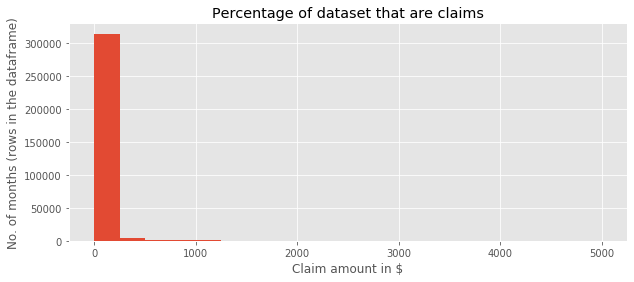

In [14]:
# Here we determing how much of our data are claims, and how many of our users have ever been claimants:
percentage_of_claimants = (combined_w_feat_df.groupby("PetId")["ClaimAmount"].sum().apply(lambda x: x > 0.00).sum() / 
                           len(combined_w_feat_df.groupby("PetId")["ClaimAmount"]))
percentage_of_claims = (len(combined_w_feat_df[combined_w_feat_df["ClaimAmount"] > 0.00]) / 
                        len(combined_w_feat_df["ClaimAmount"]))

print(f"Percentage of customers that are/have been claimants: {percentage_of_claimants}")

# To further illustrate the point, let's also create a histogram of claims (or no claims) in our data:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(combined_w_feat_df["ClaimAmount"], bins=20, range=[0, 5000])
ax.set_title("Percentage of dataset that are claims")
ax.set_ylabel("No. of months (rows in the dataframe)")
ax.set_xlabel("Claim amount in $")

print(f"Percentage of dataset that are claims: {percentage_of_claims}")


As we can see above, although 42 percent of our customers have made claims at some point (at least according to this dataset), only 7 percent of the data is comprised of claims that they made.

On the one hand, this is encouraging as it implies that most of this service's customers are healthy (and likely happy), and/or that this service is *very good* at keeping them that way. However, that does make training a model to predict how much a particular customer "costs" per month difficult as it will likely skew toward predicting less in claims than perhaps it should.

As simple and straightforward as the assessment question seemed to be, it was at this point that I suddenly realized that there's real nuance to be understood here prior to figuring out how much each customer would claim in July 2019.

I thus began wondering if we could meet the problem half way by breaking it into parts:
1. _**Will a given customer make a claim in a given month?**_
2. *If so, how much is that customer likely to claim?*

Up until this point, I've jumped to answering the second part of the problem without giving much thought to the first. There is probably a lot of value to answering whether a given customer is likely to make a claim in the first place. Is there enough there, however, to further help us predict claims off of their likelihood to claim?

It's worth a shot!

In [15]:
# In order to figure out whether or not a customer is likely to claim at all, we'll need to add/engineer 
# a few more features in our data. First, let's add a column to see whether we have pets that have or
# haven't claimed before:

combined_w_feat_df["DidTheyClaim"] = combined_w_feat_df["ClaimAmount"].apply(lambda x: x > 0.00)

# And we double-check with PetId 14, since I know that particular customer has made claims in the past:
combined_w_feat_df[combined_w_feat_df["PetId"] == 14].head()

,ServiceDate,PetId,EnrollDate,ClaimAmount,ServiceDateAsInt,EnrollDateAsInt,CancelDate,AgeAtEnroll,Species_Dog,Breed_Chihuahua,Breed_French Bulldog,Breed_Golden Retriever,Breed_Great Dane,Breed_Mixed Breed,MinAgeMonthsAtEnroll,ActiveCustomer,AgeThisMonth,RunningTotal,PastThreeClaimTotal,DidTheyClaim
369,2010-11-30,14,2010-11-13,0.00,201011,201011,2018-09-06,7 years old,1,0,0,0,0,1,84.0,False,84.0,0.00,0.00,False
370,2010-12-31,14,2010-11-13,0.00,201012,201011,2018-09-06,7 years old,1,0,0,0,0,1,84.0,False,85.0,0.00,0.00,False
371,2011-01-31,14,2010-11-13,0.00,201101,201011,2018-09-06,7 years old,1,0,0,0,0,1,84.0,False,86.0,0.00,0.00,False
372,2011-02-28,14,2010-11-13,0.00,201102,201011,2018-09-06,7 years old,1,0,0,0,0,1,84.0,False,87.0,0.00,0.00,False
373,2011-03-31,14,2010-11-13,26.48,201103,201011,2018-09-06,7 years old,1,0,0,0,0,1,84.0,False,88.0,26.48,26.48,True


This new column, "DidTheyClaim", is essentially our target for a new Random Forest Classification model we'll build to predict the probabilities that a customer will or won't claim in a given month.

Before we dive into building the classifier though, **we should return to the topic of splitting our data more intentionally to properly train our model.** Previously, I split the data arbitrarily with `train_test_split()`, and as we saw above, it didn't work out so well. Still, as we have a lot of historical data of previous pets and their claim activity, would a better, more useful way of training our model be to split our data by time?

For example, since we have claim data from November 2009 all the way up until June 2019, why not train our model on 9 years of historical data, and then test it on the final year of claim data that we have?

Let's try it!

In [16]:
# Now that we've got that "DidTheyClaim" column, we redo our splits with a new target (or, "y"):

# Notice that I'm not including the "ClaimAmount" column, as I learned the hard way doing this that including
# leads to a serious case of data leakage:
features_to_use = ['ServiceDateAsInt', 'EnrollDateAsInt', 'Species_Dog',
                   'Breed_Chihuahua', 'Breed_French Bulldog', 'Breed_Golden Retriever',
                   'Breed_Great Dane', 'Breed_Mixed Breed', 'MinAgeMonthsAtEnroll',
                   'ActiveCustomer', 'AgeThisMonth', 'RunningTotal', 'PastThreeClaimTotal']

# This started out as a data splitting experiment--thus the test2_df variable name: 
test2_df = combined_w_feat_df.copy()
test2_df.drop(["CancelDate", "AgeAtEnroll"], axis=1, inplace=True)

# Create a mask that splits the data into two halves for training and testing, with the split coming on particular
# date:
mask1 = test2_df["ServiceDateAsInt"] <= 201807

X_train = test2_df.loc[mask1, features_to_use]
y_train = test2_df.loc[mask1, 'DidTheyClaim']

mask2 = test2_df["ServiceDateAsInt"] > 201807

X_test = test2_df.loc[mask2, features_to_use]
y_test = test2_df.loc[mask2, 'DidTheyClaim']

In [17]:
# And then of course, we create our random forest classifier and dial in some hyperparameters via an 
# off-notebook grid search:
RFC = RandomForestClassifier(n_estimators=1000,
                             max_features="sqrt",
                             max_depth=10,
                             min_samples_leaf=4,
                             min_samples_split=10,
                             n_jobs=-1,
                             verbose=1)

RFC.fit(X_train, y_train)
yhat = RFC.predict(X_test)
print(f"R^2 score: {RFC.score(X_test, y_test)}")
print(classification_report(y_test, yhat))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s


R^2 score: 0.9381429413250274
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     54874
        True       0.60      0.58      0.59      4521

    accuracy                           0.94     59395
   macro avg       0.78      0.78      0.78     59395
weighted avg       0.94      0.94      0.94     59395



[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.9s finished


So our random forest classifier looks...not bad! And, certainly *much* better than our regressor performed.

According to the classification report, we got 97 percent of our "not going to claim this month" predictions correct, and 60 percent of our "will make a claim this month" predictions correct, as reflected in our precision scores for both of those classes.

Our recall scores are also interesting, as our "not going to claim this month" predictions were 97 percent correct, but our "will make a claim this month" predictions were also at 58 percent.

So, what does this imply? Again, it implies that as most of our data is comprised of customers that didn't make monthly claims, those observations are skewing the model toward favoring predictions that our customers are, on average, unlikely to claim--so much so that it gets it wrong a little under half of the time for customers that *do* end up claiming.

Although our classifier isn't perfect, it's still better than our cost prediction regression model at the moment. Also, it can provide further utility that can hopefully help our regression model: we can determine probabilities of our classification (in this instance "the probability that a customer in a given month __*won't*__ claim") and add that as a feature to our data.

Might this help improve the performance of our random forest regressor?

Only one way to find out!

In [18]:
# We call predict_proba on our model, and then simply add the probabilities as columns to our DF:
ClaimProba = RFC.predict_proba(test2_df[features_to_use])

# Since predict_proba() outputs a tuple, we want the first value in the tuple. Generally, since 0==False, and 
# 1==True, the 0th values in our predict_proba() tuple is the probability that a customer WON'T claim:
combined_w_feat_df["ProbaWontClaim"] = ClaimProba[:, 0]
combined_w_feat_df["ProbaWillClaim"] = ClaimProba[:, 1]

# And for good measure, let's tack on our model's predictions as an additional column as well:
classifier_preds = RFC.predict(test2_df[features_to_use])
combined_w_feat_df["PredWontClaim"] = classifier_preds

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    9.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    8.2s finished


In [19]:
# Time to split the data again, but this time, we're changing our target to "ClaimAmount" for the regressor:
test2_df = combined_w_feat_df.copy()
test2_df.drop(["CancelDate", "AgeAtEnroll"], axis=1, inplace=True)

features_to_use_for_RFR = ['ServiceDateAsInt', 'EnrollDateAsInt', 'Species_Dog',
                           'Breed_Chihuahua', 'Breed_French Bulldog', 'Breed_Golden Retriever',
                           'Breed_Great Dane', 'Breed_Mixed Breed', 'MinAgeMonthsAtEnroll',
                           'ActiveCustomer', 'AgeThisMonth', 'RunningTotal', 'PastThreeClaimTotal',
                           'DidTheyClaim', 'ProbaWontClaim', 'ProbaWillClaim']

mask1 = test2_df["ServiceDateAsInt"] <= 201807

X_train = test2_df.loc[mask1, features_to_use_for_RFR]
y_train = test2_df.loc[mask1, 'ClaimAmount']

mask2 = test2_df["ServiceDateAsInt"] > 201807

X_test = test2_df.loc[mask2, features_to_use_for_RFR]
y_test = test2_df.loc[mask2, 'ClaimAmount']

In [20]:
# Here's our new and improved regressor, with new hyperparameters thanks to an off-notebook grid search:
RFR = RandomForestRegressor(n_estimators=1000,
                            max_features="auto",
                            max_depth=8,
                            min_samples_leaf=5,
                            min_samples_split=10,
                            n_jobs=-1,
                            verbose=1
                           )

RFR.fit(X_train, y_train)
yhat = RFR.predict(X_test)
print(f"R^2 score: {RFR.score(X_test, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, yhat))}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


R^2 score: 0.5875185595247416
RMSE: 342.9500378530325


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


As you can see, the combination of deliberately splitting our data by time and adding in features that we can only get from our Random Forest Classifier has drastically improved the performance of our Random Forest Regressor. It's clearly not perfect, as an RMSE of $342.95 is still a pretty big amount to be off by, but it's also a lot better than where we started out!

By this point in the work, I'd finally decided to call it a day as I wasn't quite sure how to further improve our regressor model (though, as you'll see, I have some ideas for our classifier, below). While neither models are perfect doing their specific job, they can at least give us some decent insight as to what our customers might cost us in a future month if they work **together**.

For that expectated expense value, we'll have to resort to a basic confusion matrix (based on our classifier), and a cost-benefit analysis with our claims estimate (based on our regressor).

**Note:** _I should probably note here however that these are hypothetical cases I'm making up, since I'm not entirely sure how much a false positive or a false negative would cost in losses to our insurance company. If I were to do this at any company, I'd first consult the relevant stakeholders to ask what exactly we could expect from either of those cases. As such, this is more of a demonstration than anything._

In [22]:
# We split the data again since we're going back to using our classifier:

features_to_use = ['ServiceDateAsInt', 'EnrollDateAsInt', 'Species_Dog',
                   'Breed_Chihuahua', 'Breed_French Bulldog', 'Breed_Golden Retriever',
                   'Breed_Great Dane', 'Breed_Mixed Breed', 'MinAgeMonthsAtEnroll',
                   'ActiveCustomer', 'AgeThisMonth', 'RunningTotal', 'PastThreeClaimTotal']

test2_df = combined_w_feat_df.copy()
test2_df.drop(["CancelDate", "AgeAtEnroll"], axis=1, inplace=True)

mask1 = test2_df["ServiceDateAsInt"] <= 201807

X_train = test2_df.loc[mask1, features_to_use]
y_train = test2_df.loc[mask1, 'DidTheyClaim']

mask2 = test2_df["ServiceDateAsInt"] > 201807

X_test = test2_df.loc[mask2, features_to_use]
y_test = test2_df.loc[mask2, 'DidTheyClaim']

# And of course, here's our classifier:
RFC = RandomForestClassifier(n_estimators=1000,
                             max_features="sqrt",
                             max_depth=10,
                             min_samples_leaf=4,
                             min_samples_split=10,
                             n_jobs=-1,
                             verbose=1)

RFC.fit(X_train, y_train)
yhat = RFC.predict(X_test)

# Here's where we first make our confusion matrix (based on our test set):
classifier_conf_mat = confusion_matrix(y_test, yhat, labels=[False,True])
print(classifier_conf_mat)
print(classification_report(y_test, yhat))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.2s


[[53061  1813]
 [ 1867  2654]]
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     54874
        True       0.59      0.59      0.59      4521

    accuracy                           0.94     59395
   macro avg       0.78      0.78      0.78     59395
weighted avg       0.94      0.94      0.94     59395



[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.6s finished


Cool. So what does this matrix mean? Well, it basically means this:

|            |Pred WON'T CLAIM|Predicted CLAIM |
|------------|----------------|----------------|
|Act NO CLAIM|53061           |1813            |
|Act CLAIMED |1867            |2654            |

With "Pred" being short for "predicted" and "Act" short for "actual".

The confusion matrix breaks down as follows:
- **True Negative:** 53061 accurately predicted by the model NOT to file a claim (so, guaranteed to cost the insurance company $0 in claims payouts)
- **False Positive:** 1813 inaccurately predicted by the model to file (meaning we might set aside some monies for these expected claims, but as these customers won't claim, actual total expenses will likely be less than anticipated)
- **False Negative:** 1867 inaccurately predicted NOT to file (these are costly unexpected expenses that will eat away at profit because our model didn't anticipate these customers making claims)
- **True Positive:** 2654 accurately predicted to file (will need to use regressor to estimate expected expenses, which in turn will give us a value for what we can expect to pay out)

Our model's performance can also be explained thusly:
- **Sensitivity** or **Recall of the Positive Class (TP / (TP+FN):** 0.59, or that our model correctly identifies 59 percent of customers that will claim.
- **Specificity** or **Recall of the Negative Class (TN / (TN+FP):** 0.97, or that our model correctly identifies 97 percent of customers that won't claim.

The question at this point becomes, "which is more valuable a classification to get right?" Naturally, our model is really good at predicting customers that won't claim, and the reason for why seems intuitively to be due to the overwhelming amount of zero-claim months in the data. But, since we are probably more interested in who claims and how much because of the cost implications, our model seems not so great at correctly predicting those customers 58 percent of the time.

So, what can we do? Tweaking the model could make it better, but if many hours of hyperparameter tuning via grid searches has taught me anything, it's that those gains would probably be modest at best. If it's more important to correctly classify which customers will be making claims, *even at the expense of getting more false positives (or customers that we say will claim but in reality won't)*, then we could perhaps adjust the threshold of classification to go easier on picking up potential claimants. 

In this way, we're kind of devising a "worst-case-scenario," guaranteeing that we'll have the proper amount of money on-hand for claims, rather than being caught off-guard.

To illustrate this point, let's draw an ROC curve and a threshold that favors classifying more true positives.

In [23]:
# Predicting probabilities for the classifier and for the "guessing 50/50" line (again, using our test set):
bat_500_probas = [0 for n in range(len(y_test))]
RFC_probas = RFC.predict_proba(X_test)
# We only want the probability for the positive class (which is the prob. that a customer WILL claim this month):
RFC_probas = RFC_probas[:, 1]

# Calculate AUC scores
bat_500_auc = roc_auc_score(y_test, bat_500_probas)
RFC_auc = roc_auc_score(y_test, RFC_probas)

# Calculate ROC curves
bat_500_FPR, bat_500_TPR, bat_500_thresh = roc_curve(y_test, bat_500_probas)
RFC_probas_FPR, RFC_probas_TPR, RFC_probas_thresh = roc_curve(y_test, RFC_probas)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.9s finished


AUC score for guessing 50/50: 0.5
AUC score for our classifier: 0.9698228034049926


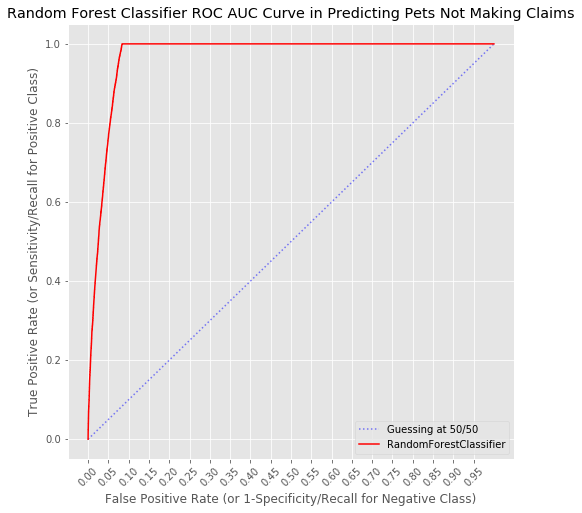

In [24]:
# And now, we plot the curves and print out our AUC scores:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(bat_500_FPR, bat_500_TPR, linestyle=":", label="Guessing at 50/50", color="blue", alpha=0.5)
ax.plot(RFC_probas_FPR, RFC_probas_TPR, linestyle="-", label="RandomForestClassifier", color="red")
ax.set_xticks(np.arange(min(RFC_probas_FPR), max(RFC_probas_FPR), .05))
ax.set_title("Random Forest Classifier ROC AUC Curve in Predicting Pets Not Making Claims")
ax.set_xlabel("False Positive Rate (or 1-Specificity/Recall for Negative Class)")
ax.set_ylabel("True Positive Rate (or Sensitivity/Recall for Positive Class)")
ax.legend()
plt.xticks(rotation=45)

print(f"AUC score for guessing 50/50: {bat_500_auc}")
print(f"AUC score for our classifier: {RFC_auc}")

Just eyeballing it, this ROC curve actually looks really promising in that we can set our threshold a bit lower without gaining too many more false positives. (In fact, it looks like we can get 100 percent of our true positives while letting in about 6-8 percent of false positives.) 

Our AUC seems pretty high up there too, so that's a plus and means that our model (with a bit of threshold adjustment) is probably pretty good and would give us decent enough results such that other models, like say a standard logisitic regression, XGBoost, etc., may not be better or entirely necessary.

In [25]:
threshold = 0.36

predicted_proba = RFC.predict_proba(X_test)
thresh_yhat = (predicted_proba[:, 1] >= threshold).astype('int')

new_classification_rpt = classification_report(y_test, thresh_yhat)
print(new_classification_rpt)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.9s


              precision    recall  f1-score   support

       False       1.00      0.92      0.96     54874
        True       0.50      0.99      0.66      4521

    accuracy                           0.92     59395
   macro avg       0.75      0.95      0.81     59395
weighted avg       0.96      0.92      0.93     59395



[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.5s finished


With a threshold of 0.36, we intentionally favor probabilities from our model's positive class such that we'll now predict that 36 percent and above means it will predict that a customer *will* file a claim (as opposed to the default 0.50, where it will only predict a claim at or above 50 percent). 

Setting the threshold at 0.36 allows us to "catch" almost 99 percent of those that *do* actually file, and so we've boosted our true positive catch. However, we also predict accurately 92 percent of those that don't, so that remaining 8 percent end up as false positives that get caught up along with our greater number of true positives. Again, it's not perfect, but this seems a much safer way by which to estimate who will claim so we can set aside funds for them in a given month without being caught off guard by an overwhelming amount of false negatives (where we neglected to properly predict those customers that actually do claim).

So, all that said and done, what does this threshold in action look like in terms of customers who will claim in July of 2019? Well, probably something like this:

In [31]:
# First, we need to rerun our regressor and append its predicted claims ("meh" as they are) to our DF:
test2_df = combined_w_feat_df.copy()
test2_df.drop(["CancelDate", "AgeAtEnroll"], axis=1, inplace=True)

features_to_use_for_RFR = ['ServiceDateAsInt', 'EnrollDateAsInt', 'Species_Dog',
                           'Breed_Chihuahua', 'Breed_French Bulldog', 'Breed_Golden Retriever',
                           'Breed_Great Dane', 'Breed_Mixed Breed', 'MinAgeMonthsAtEnroll',
                           'ActiveCustomer', 'AgeThisMonth', 'RunningTotal', 'PastThreeClaimTotal',
                           'DidTheyClaim', 'ProbaWontClaim', 'ProbaWillClaim']

mask1 = test2_df["ServiceDateAsInt"] <= 201807

X_train = test2_df.loc[mask1, features_to_use_for_RFR]
y_train = test2_df.loc[mask1, 'ClaimAmount']

mask2 = test2_df["ServiceDateAsInt"] > 201807

X_test = test2_df.loc[mask2, features_to_use_for_RFR]
y_test = test2_df.loc[mask2, 'ClaimAmount']

# And here's the regressor, again:
RFR = RandomForestRegressor(n_estimators=1000,
                            max_features="auto",
                            max_depth=8,
                            min_samples_leaf=5,
                            min_samples_split=10,
                            n_jobs=-1,
                            verbose=1)

RFR.fit(X_train, y_train)
yhat = RFR.predict(X_test)

# These printouts are just to remind us of how it performs:
print(f"R^2 score: {RFR.score(X_test, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, yhat))}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


R^2 score: 0.5866727224198445
RMSE: 343.3014855559563


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


In [38]:
# And then, we append its predictions to the combined_w_feat_df dataframe:
ClaimAmtPred = RFR.predict(test2_df[features_to_use_for_RFR])
combined_w_feat_df["ClaimAmtPred"] = ClaimAmtPred

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.8s finished


In [45]:
# And now, we filter out only the pets that are both actively enrolled in July 2019 AND likely to claim, per 
# our set threshold: 
active_july_customers = combined_w_feat_df.copy()[combined_w_feat_df["ServiceDateAsInt"] == 201907]

# Just by way of comparison (these are nice-to-know details more than anything):
no_claimants_36 = len(active_july_customers[active_july_customers["ProbaWillClaim"] >= 0.36])
no_claimants_50 = len(active_july_customers[active_july_customers["ProbaWillClaim"] >= 0.50])
print(f"No. of pred claimants (threshold 0.36): {no_claimants_36}")
print(f"No. of pred claimants (threshold 0.50): {no_claimants_50}")

july_claimants = active_july_customers.copy()[active_july_customers["ProbaWillClaim"] >= 0.36]
july_claimants[july_claimants["ClaimAmtPred"] > 0.0]

No. of pred claimants (threshold 0.36): 625
No. of pred claimants (threshold 0.50): 306


,ServiceDate,PetId,EnrollDate,ClaimAmount,ServiceDateAsInt,EnrollDateAsInt,CancelDate,AgeAtEnroll,Species_Dog,Breed_Chihuahua,Breed_French Bulldog,Breed_Golden Retriever,Breed_Great Dane,Breed_Mixed Breed,MinAgeMonthsAtEnroll,ActiveCustomer,AgeThisMonth,RunningTotal,PastThreeClaimTotal,DidTheyClaim,ProbaWontClaim,ProbaWillClaim,PredWontClaim,ClaimAmtPred
9315,2019-07-31,270,2013-01-03,0.00,201907,201301,NaT,8 weeks to 12 months old,1,0,0,0,0,1,0.7,True,78.7,58312.51,22634.66,False,0.336359,0.663641,True,32.426437
23316,2019-07-31,713,2010-06-15,0.00,201907,201006,2019-07-09,8 weeks to 12 months old,1,0,0,0,0,1,0.7,False,109.7,54197.81,48691.46,False,0.281760,0.718240,True,145.453218
36611,2019-07-31,1139,2019-06-27,830.13,201907,201906,NaT,2 years old,0,0,0,0,0,1,24.0,True,25.0,830.13,830.13,True,0.514191,0.485809,False,571.370389
128106,2019-07-31,3944,2017-01-03,164.12,201907,201701,NaT,8 weeks to 12 months old,1,0,0,0,0,1,0.7,True,30.7,325.12,164.12,True,0.596600,0.403400,False,137.197808
129273,2019-07-31,3977,2015-02-23,16.46,201907,201502,NaT,9 years old,1,0,0,0,0,1,108.0,True,161.0,10187.78,1127.13,True,0.257527,0.742473,True,433.371513
182711,2019-07-31,5654,2011-05-27,1726.84,201907,201105,NaT,8 weeks to 12 months old,1,0,0,1,0,0,0.7,True,98.7,7170.00,1929.64,True,0.378949,0.621051,True,946.438513
211138,2019-07-31,6478,2013-07-17,57.71,201907,201307,NaT,5 years old,1,0,0,0,0,1,60.0,True,132.0,11133.06,464.97,True,0.371060,0.628940,True,245.256444
279545,2019-07-31,8628,2013-03-24,0.00,201907,201303,NaT,8 weeks to 12 months old,1,0,0,0,0,1,0.7,True,76.7,50477.41,24224.61,False,0.338571,0.661429,True,32.426437
286725,2019-07-31,8860,2012-09-26,752.00,201907,201209,NaT,4 years old,1,0,0,0,1,0,48.0,True,130.0,4833.36,752.00,True,0.404873,0.595127,True,422.421783


In [46]:
# And here, we can find out what the total amount in claims in July (as predicted) will be:
july_claimants["ClaimAmtPred"].sum()

2966.362543262607

Again, given that our regressor isn't that great (despite it coming a long way!), these nine customers (out of about 5000 or so active customers) are predicted to claim about \\$2966.36 total in July 2019...give or take $343.30 for all 625 predicted to be claiming some amount of insurance that same month.

*le sigh...*

I admit, my model and solution were not perfect, but the exercise in building it, reassing, and rebuilding has been an invaluable educational journey. I personally have learned a lot, for which I greatly appreciate this exercise. I hope that some day, I can figure out how better to think about how to tackle such a straightforward, but complex question with the correct amount of nuance and consideration to give the (near) perfect answer.

In the meantime, I'm going to tack on a few observations below that I made in my other "work" notebook that I thought were interesting that hinted toward stories in the data that might otherwise have been glossed over in its vastness.

#### The Case of Great Dane 4991:

The data for this particular good dog tells a pretty heartwrenching tale. In particular, look at the probabilities that this Great Dane will likely need to file a claim in the `ProbaWillClaim` column. As we move down each row, it grows older by a month, and its probabilities of filing a claim begin to climb over its nearly 10 (human) years of life. By its final months, it's almost guaranteed to be needing veterinary services and will claim for them. 

In [51]:
pet_4991 = combined_w_feat_df[combined_w_feat_df["PetId"]==4991]
combined_w_feat_df[combined_w_feat_df["PetId"]==4991][["ServiceDate", "PetId", "Breed_Great Dane", "AgeThisMonth",
                                                       "ClaimAmount", "DidTheyClaim", "RunningTotal", 
                                                       "ProbaWillClaim", "ClaimAmtPred"]]

,ServiceDate,PetId,Breed_Great Dane,AgeThisMonth,ClaimAmount,DidTheyClaim,RunningTotal,ProbaWillClaim,ClaimAmtPred
162445,2010-04-30,4991,1,0.7,0.00,False,0.00,0.003456,0.000000
162446,2010-05-31,4991,1,1.7,0.00,False,0.00,0.003411,0.000000
162447,2010-06-30,4991,1,2.7,0.00,False,0.00,0.001309,0.000000
162448,2010-07-31,4991,1,3.7,0.00,False,0.00,0.001334,0.000000
162449,2010-08-31,4991,1,4.7,0.00,False,0.00,0.001254,0.000000
162450,2010-09-30,4991,1,5.7,0.00,False,0.00,0.001246,0.000000
162451,2010-10-31,4991,1,6.7,0.00,False,0.00,0.001246,0.000000
162452,2010-11-30,4991,1,7.7,0.00,False,0.00,0.001246,0.000000
162453,2010-12-31,4991,1,8.7,0.00,False,0.00,0.001280,0.000000
162454,2011-01-31,4991,1,9.7,0.00,False,0.00,0.001280,0.000000


Its running total by the end of its life is also incredibly high at $67687. 

This poor thing seemed to be plagued with costly health issues for most of its life, and its owner (and the insurance service that cared for it) was reliably there for it every month, giving it the care it desperately needed. 

It's heartbreaking and bittersweet to imagine just how much this animal might have suffered, and yet, just how much it was loved as there were clearly people there that dilligently took care of it every month. 

This dog was family.

Text(0, 0.5, 'Probability of PetId 4991 Filing A Claim')

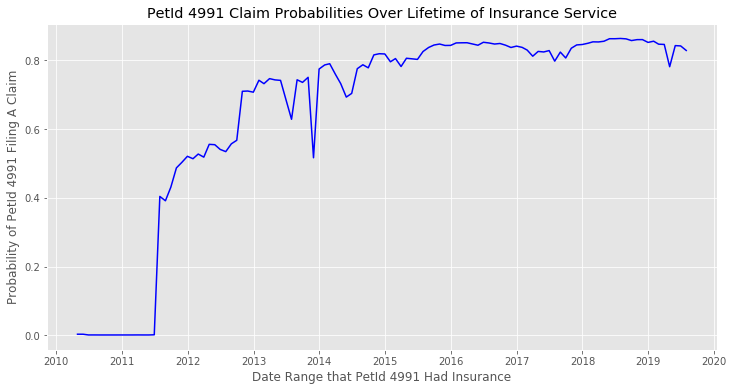

In [49]:
# Here's a visual representation of 4991's probability of making claims over its lifetime:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pet_4991["ServiceDate"], pet_4991["ProbaWillClaim"], color="blue")
ax.set_title("PetId 4991 Claim Probabilities Over Lifetime of Insurance Service")
ax.set_xlabel("Date Range that PetId 4991 Had Insurance")
ax.set_ylabel("Probability of PetId 4991 Filing A Claim")

#### Pandas Profiling: A Fun and Useful EDA Tool

Typically, I would take my numerical values in a dataframe and pass it through Pandas' scatter_matrix to visually key in on feature correlations. That being said, there's also another tool that does that work explicitly *and more*, and it's called Pandas Profiling. 

You may have noticed that I loaded it up at the top in my first cell with all my imports, however, given how overwhelming a flood of information it can be, I've decided to tuck it all the way down here. It's not integral, but it *is* useful, and I think ought to be shared with *everyone* that needs to do EDA.

In [53]:
pandas_profiling_feats = ['PetId', 'ClaimAmount', 'ServiceDateAsInt', 'EnrollDateAsInt', 
                          'AgeAtEnroll', 'Species_Dog', 'Breed_Chihuahua', 'Breed_French Bulldog', 
                          'Breed_Golden Retriever', 'Breed_Great Dane', 'Breed_Mixed Breed', 
                          'MinAgeMonthsAtEnroll', 'ActiveCustomer', 'AgeThisMonth', 'RunningTotal', 
                          'PastThreeClaimTotal', 'DidTheyClaim', 'ProbaWontClaim', 'ProbaWillClaim', 
                          'PredWontClaim', 'ClaimAmtPred']

pet_claim_profile = ProfileReport(combined_w_feat_df[pandas_profiling_feats])

pet_claim_profile

Number of variables,21
Number of observations,324207
Total Missing (%),0.0%
Total size in memory,34.9 MiB
Average record size in memory,113.0 B
Numeric,10
Categorical,2
Boolean,9
Date,0
Text (Unique),0
Rejected,0


In [55]:
petdata_ppf_feats = ['PetId', 'EnrollDate', 'CancelDate', 'Species', 'Breed', 'AgeAtEnroll']

petdata_profile = ProfileReport(petdata[petdata_ppf_feats])

petdata_profile

Number of variables,6
Number of observations,10000
Total Missing (%),8.5%
Total size in memory,468.8 KiB
Average record size in memory,48.0 B
Numeric,1
Categorical,3
Boolean,0
Date,2
Text (Unique),0
Rejected,0


In [56]:
claimdata_ppf_feats = ['ClaimId', 'PetId', 'ClaimDate', 'ClaimAmount']

claimdata_profile = ProfileReport(claimdata[claimdata_ppf_feats])

claimdata_profile

Number of variables,4
Number of observations,37049
Total Missing (%),0.0%
Total size in memory,1.1 MiB
Average record size in memory,32.0 B
Numeric,3
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,0


So, some really quick, cool takeaways from these profiles:
- Probably needless to say, but there are obvious positive and negative correlations between things like breeds and species, claim amounts and running totals, and claim amounts and probabilities of not claiming, however if Pandas Profiling is picking up obvious correlations (say for example between things like claim amounts, the probability of cliams, and later when the regressor is fitted, the claim amount prediction, it does give us hope that the models are picking up on things that should in theory make for sensible predictions.
- Speaking of which, there's a very light correlation between claim amounts and a pet's age at a given month, their minimum age at enrollment, and lesser so with service date, and dogs in general . These seem to make intuitive sense.
- The majority of our data was comprised of pets that were enrolled as newborns or up to one year of age (good job, pet owners!)
- Mixed breed animals make up 76% of the data (this includes cats and dogs), 
- Mixed breed cats and dogs aside, it appears that Golden Retrievers (9.8%), Chihuahuas (6.9%), French Bulldogs (4.3%), Great Danes (1.9%), and Ragdoll cats (1.1%) were popular in that specific order.
- We seemed to have a spike in enrollment in both the beginning of 2015 and 2019. I'm sure we could take a closer look, but I'm a little curious if these two years correspond with increased pet adoptions or sales?
- Of our customers, dogs appear to be more popular than cats given that they comprise 61.4% of our clientele.
- From the beginning of our data in 2009 to June 2019, we've paid out approximately \\$15,079,000 (!!!) in claims
- Claims steadily rose between 2009 and 2019, likely due to the growing number of customers and the aging of our existing customers

#### Last, but not least:

This is kind of a neat detail: PetId 6580 historically had the highest total insurance claims at a massive \\$110,202.38.

The next highest, PetId 9633, claimed \\$22,257.46 less, but it's still a whopping total of \\$87,944.92.

I can only imagine how rough both pets might have had things, but thank goodness for the people that love them and for the pet insurance they got for them!

In [48]:
combined_w_feat_df.groupby("PetId")["ClaimAmount"].sum().sort_values(ascending=False)

PetId
6580    110202.38
9633     87944.92
3241     71091.93
7243     67790.78
4991     67687.66
4219     64213.65
4007     58428.10
270      58312.51
9351     57184.47
713      54197.81
4421     50796.51
2922     50604.34
8628     50477.41
2290     49339.52
9390     48931.80
9587     46494.25
1613     45571.63
8664     45571.10
1203     45043.56
3902     43931.28
8250     43570.01
5466     43092.71
5572     41879.38
5997     40567.31
4782     40144.83
9801     39394.88
2723     38843.66
1282     38459.70
7050     38199.30
3767     36014.71
          ...    
5856         0.00
5857         0.00
5804         0.00
5802         0.00
5755         0.00
5801         0.00
5756         0.00
5758         0.00
5759         0.00
5760         0.00
5762         0.00
5764         0.00
5765         0.00
5766         0.00
5767         0.00
5769         0.00
5770         0.00
5775         0.00
5778         0.00
5780         0.00
5781         0.00
5782         0.00
5784         0.00
5785         0.00
5789

Similarly, our poor Great Dane 4991 was the pet that claimed the most often, with 84 months in which they made claims over their lifetime.

In [50]:
combined_w_feat_df.groupby("PetId")["DidTheyClaim"].sum().sort_values(ascending=False)

PetId
4991    84.0
2922    71.0
1517    70.0
3957    70.0
1776    64.0
4674    63.0
270     60.0
261     59.0
8838    59.0
3522    58.0
6560    57.0
8834    57.0
4053    54.0
7050    54.0
3723    53.0
8482    52.0
6409    49.0
76      49.0
2141    49.0
2939    48.0
4712    48.0
2809    48.0
8874    48.0
5332    47.0
3205    47.0
1381    47.0
3973    47.0
9633    47.0
356     47.0
4234    46.0
        ... 
5856     0.0
5857     0.0
5804     0.0
5802     0.0
5755     0.0
5801     0.0
5756     0.0
5758     0.0
5759     0.0
5760     0.0
5762     0.0
5764     0.0
5765     0.0
5766     0.0
5767     0.0
5769     0.0
5770     0.0
5775     0.0
5778     0.0
5780     0.0
5781     0.0
5782     0.0
5784     0.0
5785     0.0
5789     0.0
5790     0.0
5793     0.0
5796     0.0
5800     0.0
0        0.0
Name: DidTheyClaim, Length: 9603, dtype: float64

### Part 2 – Short Answer
>*Suppose our team is tasked with going into another insurance company and building an end-to-end solution to automate their claims process. Provide a summary of the work that needs to be done to accomplish this task.*

Well, first and foremost, I would want to consult with key stakeholders at this allied insurance company to better understand how they do business and what their primary goals and/or problems are, and see if there's a way that we can help them (as not all problems are data science problems). It's usually a good idea to sit down to build this kind of understanding and context first as it not only familiarizes our team with what benchmarks and goals our clients may want to hit, but it also builds confidence and trust that these stakeholders are being seen and heard.

Next, I imagine we'd want to figure out the environment we'll be working in; in particular, what kind of data this allied insurance company collects (if they are actively collecting at all at this point), and how. Databases may need to be set up, and pipelines created for the benefit of our team, as well as any data analyst/scientist teams that may follow us.

Should that architecture not already exist, I'd likely reach out to (data) engineers to create the databases and pipelines while also having them coordinate with our team of data scientists/analysts to register our unique requests given our understanding of the tasks set forth by the allied insurance company such that what's eventually built gives us the easiest and quickest access to the data, and allows us to rapidly produce analysis and iterate on models.

Once the architecture is set up and we're collecting and exploring the most current data, we'll likely want to create basic EDA to demonstrate to our key stakeholders what we're observing in the data. This is a good time to do sanity checks, to ensure that things aren't wildly misinterpreted and that we're all on the same page, understanding the narrative that the data is conveying. I imagine that it would be at this point where serendipitous discoveries might happen that can be shared with our stakeholders, which in turn would sharpen their understanding of their business and may lead to new stretch goals, milestones, or experiments that they'd like us as data scientists to try out on their behalf.

Say we get all those goals in order, start modeling, and produce a production-ready model (or models) that helps them do what they want. The next step would be creating dashboards and similar GUI tools that can pull and ingest the data from the databases via the pipelines we may or may not have helped create, and then output the desired predictions in an easily digestible way for non-data people to do once we're done.

After that, then maybe we celebrate with axe-throwing, a team visit to a dog park, a game night, happy hour, and/or all of the above?